In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keeistu","key":"1d61b53a06b77bd72e9b58c00a4e1458"}'}

In [2]:
# Colab cell 2: (bash)
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!mkdir -p data/HAM10000
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p data/HAM10000 --unzip
!ls -la data/HAM10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [02:09<00:00, 26.1MB/s]
100% 5.20G/5.20G [02:09<00:00, 43.0MB/s]
total 130800
drwxr-xr-x 6 root root     4096 Nov 18 19:32 .
drwxr-xr-x 3 root root     4096 Nov 18 19:24 ..
drwxr-xr-x 2 root root   163840 Nov 18 19:32 ham10000_images_part_1
drwxr-xr-x 2 root root   163840 Nov 18 19:31 HAM10000_images_part_1
drwxr-xr-x 2 root root   167936 Nov 18 19:32 ham10000_images_part_2
drwxr-xr-x 2 root root   167936 Nov 18 19:31 HAM10000_images_part_2
-rw-r--r-- 1 root root   563277 Nov 18 19:31 HAM10000_metadata.csv
-rw-r--r-- 1 root root 30807979 Nov 18 19:32 hmnist_28_28_L.csv
-rw-r--r-- 1 root root 91820383 Nov 18 19:32 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root  2537778 Nov 18 19:32 hmnist_8_8_L.csv
-rw-r--r-- 1 root root  7524968 Nov 18 19:32 hmnist_8_8_RGB.csv


In [4]:
"""
2 ways to load HAM10000 dataset for skin cancer lesion classification
Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description:
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc)
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


'\n2 ways to load HAM10000 dataset for skin cancer lesion classification\nDataset link:\nhttps://www.kaggle.com/kmader/skin-cancer-mnist-ham10000\nData description:\nhttps://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf\n\nThe 7 classes of skin cancer lesions included in this dataset are:\nMelanocytic nevi (nv)\nMelanoma (mel)\nBenign keratosis-like lesions (bkl)\nBasal cell carcinoma (bcc)\nActinic keratoses (akiec)\nVascular lesions (vas)\nDermatofibroma (df)\n'

In [5]:
!python -m pip install --upgrade pip
!python -m pip install numpy pandas matplotlib pillow tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [6]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


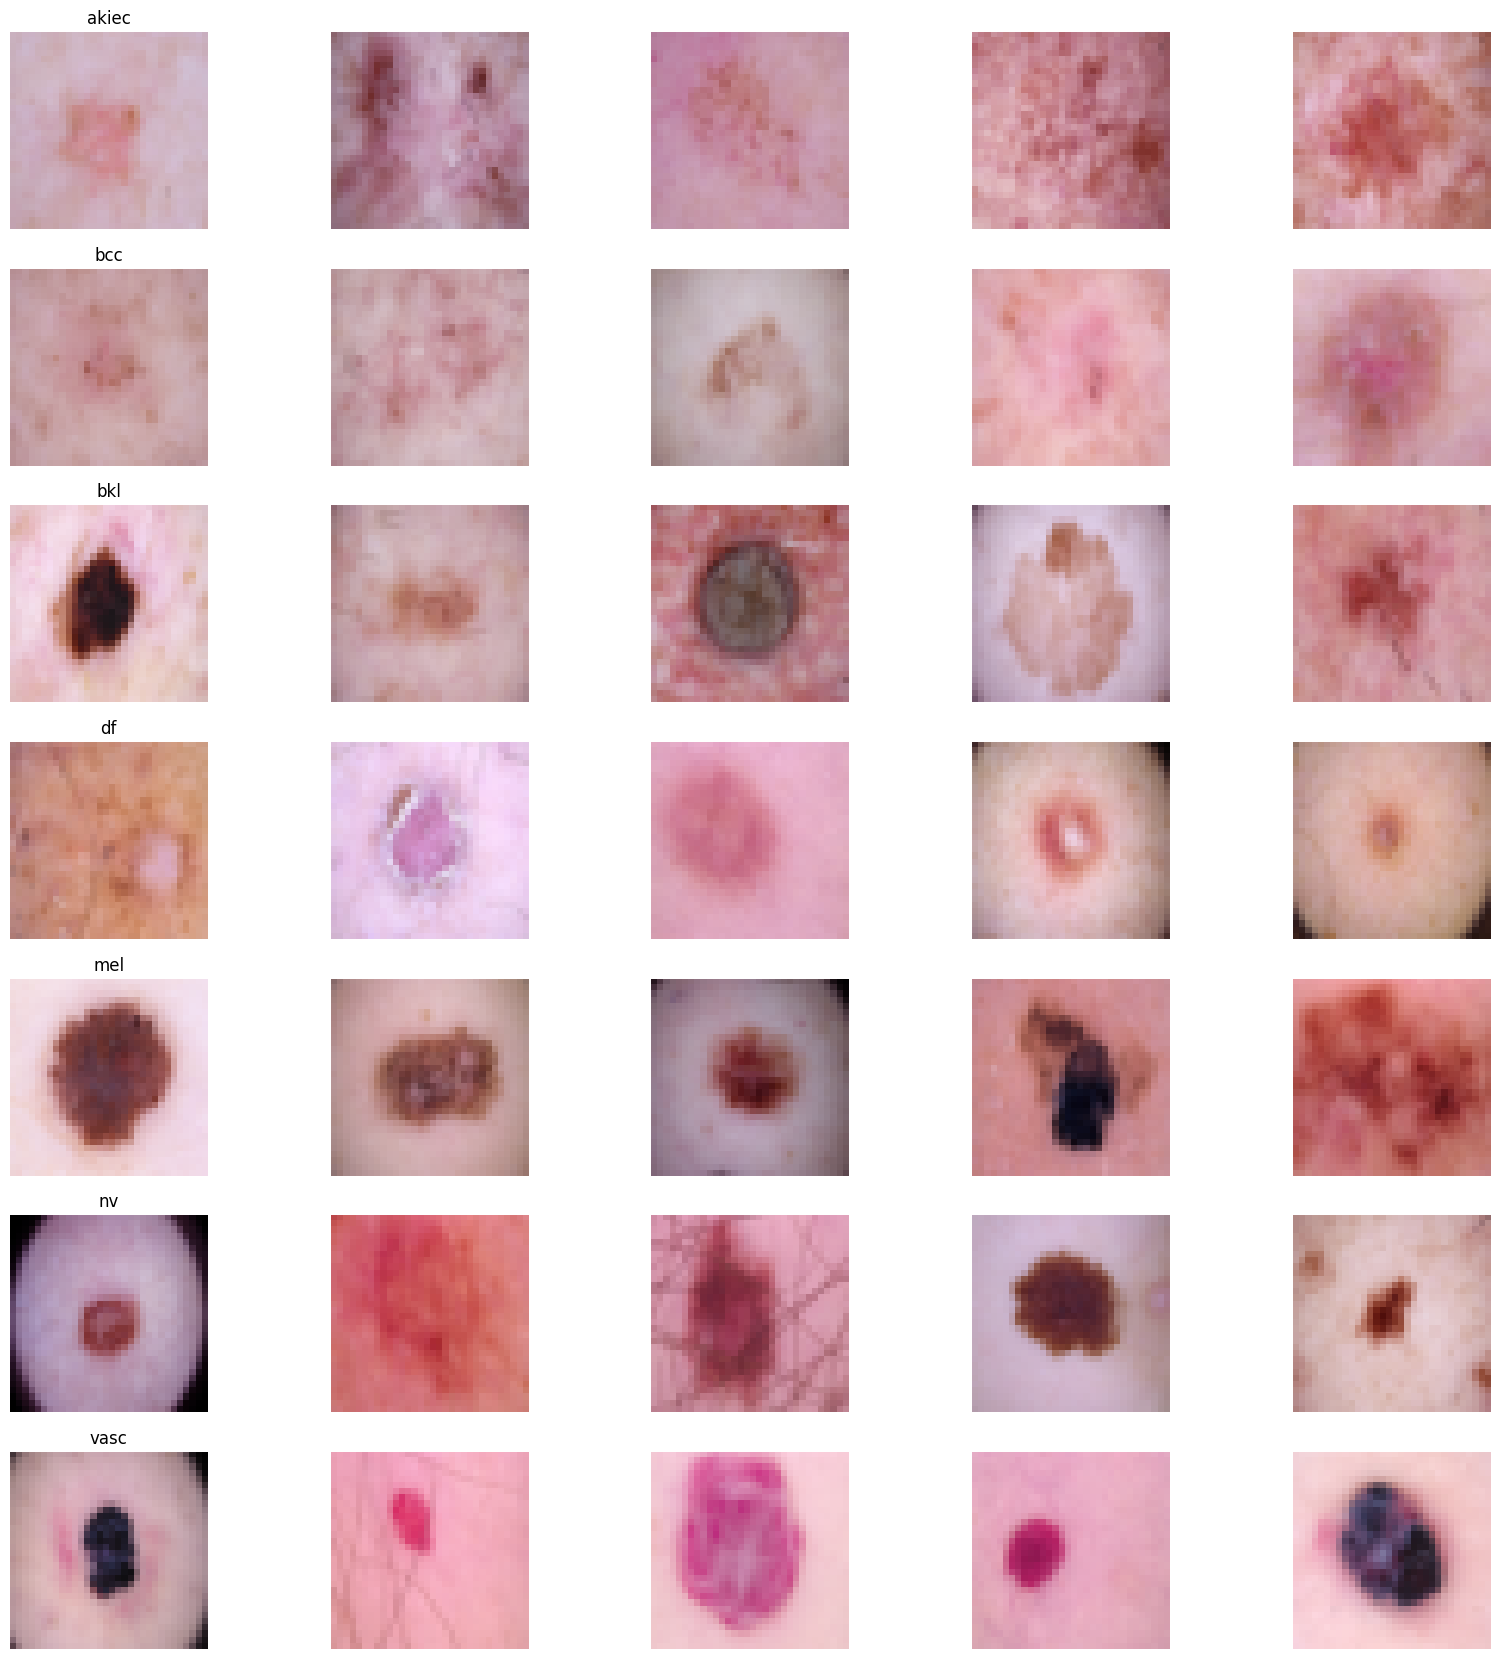

In [7]:
###########################################
#METHOD 1: Read files using file name from the csv and add corresponding
#image in a pandas dataframe along with labels.
#This requires lot of memory to hold all thousands of images.
#Use datagen if you run into memory issues.

skin_df = pd.read_csv('/content/data/HAM10000/HAM10000_metadata.csv')

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(skin_df['dx'].value_counts())

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [8]:
#############################################################################
# Reorganize data into subfolders based on their labels
#then use keras flow_from_dir or pytorch ImageFolder to read images with
#folder names as labels

#Sort images to subfolders first
import pandas as pd
import os
import shutil

# Dump all images into a folder and specify the path:
data_dir = os.getcwd() + "/data/all_images/"

# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "/data/reorganized/"

# Read the csv file containing image names and corresponding labels
skin_df2 = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())

label=skin_df2['dx'].unique().tolist()  #Extract labels into a list
label_images = []


# Copy images to new folders
for i in label:
    os.makedirs(dest_dir + str(i) + "/", exist_ok=True)
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        # Ensure the source file path is correct. The `data_dir` should point to where the JPGs are.
        # From the `ls` command in the notebook state, images are in `data/HAM10000/ham10000_images_part_1/` and `data/HAM10000/ham10000_images_part_2/`
        # The original code's `data_dir` was `/content/data/all_images/` which seems to be incorrect based on previous `kaggle datasets download` command.
        # Let's adjust this to correctly find the images.
        # Assuming images are directly in `data/HAM10000/` or its subfolders `ham10000_images_part_1`, `ham10000_images_part_2`.
        # The `image_path` dictionary created in the previous cell (GTSPwnOc6aUo) correctly maps image_id to full path.
        # Let's use that for robustness.
        source_image_path = image_path.get(id)
        if source_image_path:
            shutil.copyfile(source_image_path, (dest_dir + i + "/"+id+".jpg"))
        else:
            print(f"Warning: Image {id}.jpg not found at expected path.")
    label_images=[]

#Now we are ready to work with images in subfolders

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Found 10015 images belonging to 7 classes.


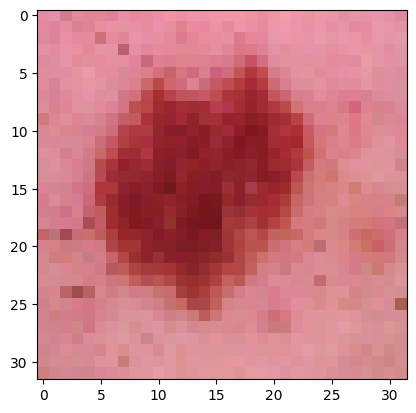

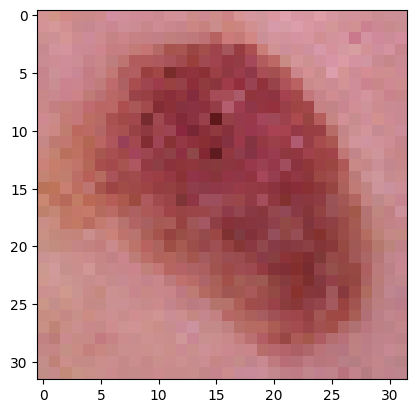

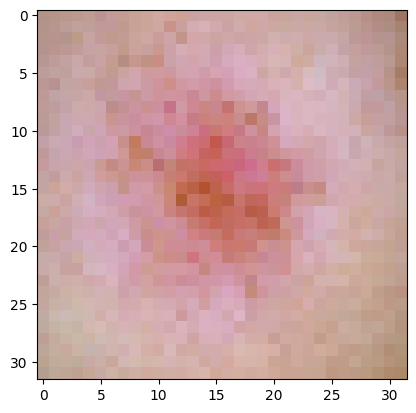

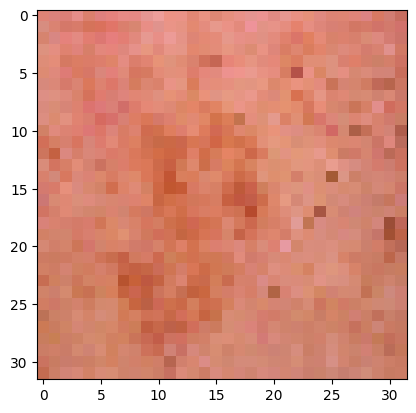

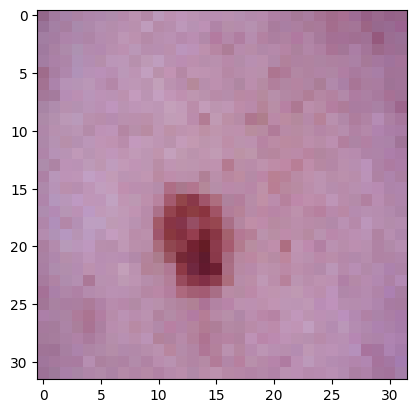

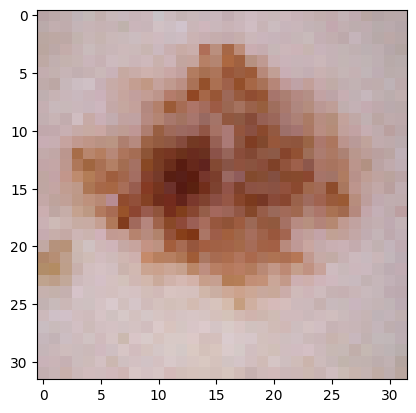

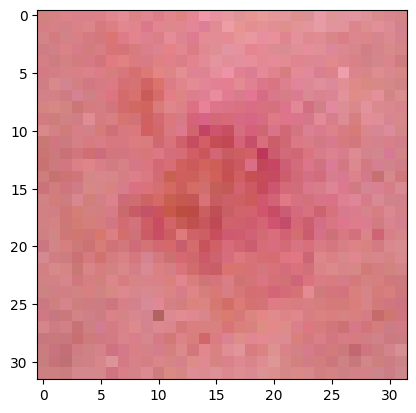

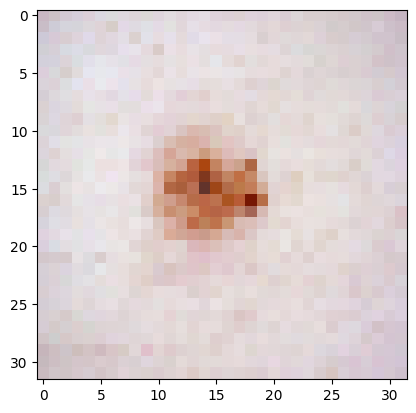

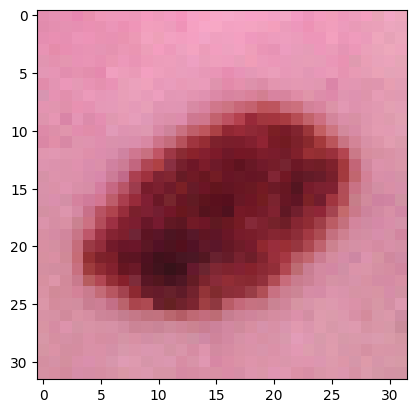

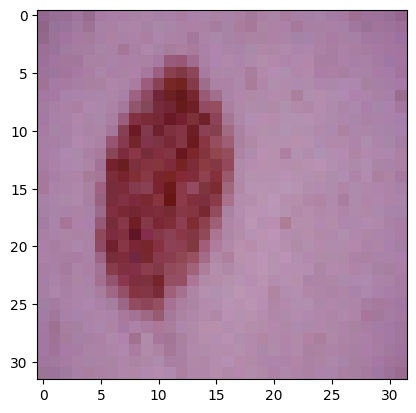

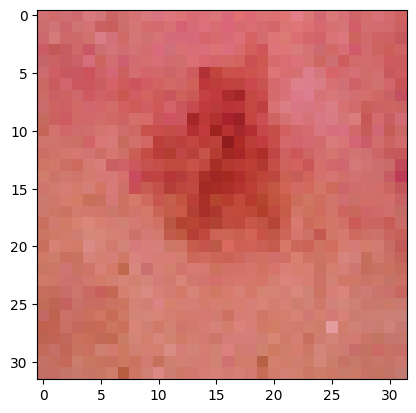

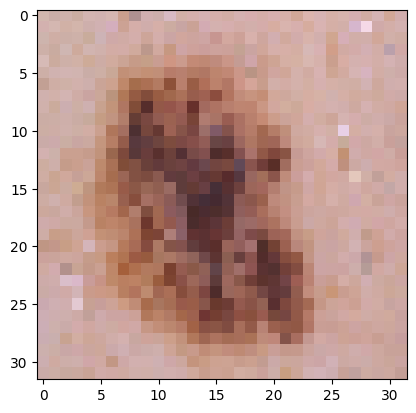

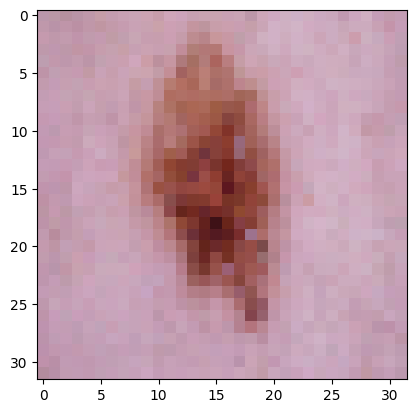

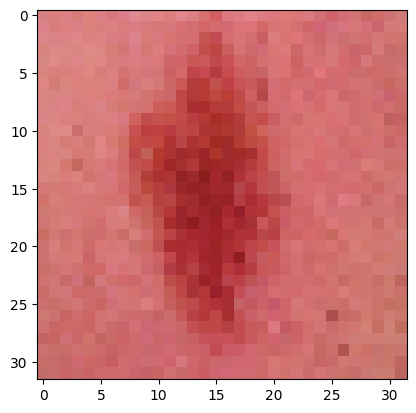

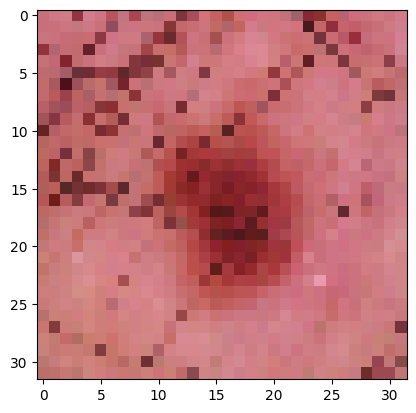

In [9]:
### FOR Keras datagen ##################################
#flow_from_directory Method
#useful when the images are sorted and placed in there respective class/label folders
#identifies classes automatically from the folder name.
# create a data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from matplotlib import pyplot as plt

#Define datagen. Here we can define any transformations we want to apply to images
datagen = ImageDataGenerator()

# define training directory that contains subfolders
train_dir = os.getcwd() + "/data/reorganized/"
#USe flow_from_directory
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16,  #16 images at a time
                                         target_size=(32,32))  #Resize images

#We can check images for a single batch.
x, y = next(train_data_keras)
#View each image
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

#Now you can train via model.fit_generator



In [10]:
##################################################################################
### Similarly FOR PYTORCH we can use DataLoader
import torchvision
from torchvision import transforms
import torch.utils.data as data
import numpy as np

#Define root directory with subdirectories
train_dir = os.getcwd() + "/data/reorganized/"

#If you want to apply ransforms
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),       # Converts your input image to PyTorch tensor.
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] )
    ])

#With transforms
#train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
#Without transforms
train_data_torch = torchvision.datasets.ImageFolder(root=train_dir)
#train_data_loader_torch = data.DataLoader(train_data_torch, batch_size=len(train_data_torch))

print("Number of train samples: ", len(train_data_torch))
print("Detected Classes are: ", train_data_torch.class_to_idx) # classes are detected by folder structure

labels = np.array(train_data_torch.targets)
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

Number of train samples:  10015
Detected Classes are:  {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
[[   0  327]
 [   1  514]
 [   2 1099]
 [   3  115]
 [   4 1113]
 [   5 6705]
 [   6  142]]


Trial 25 Complete [00h 00m 09s]
val_loss: 4.190535068511963

Best val_loss So Far: 1.2777419090270996
Total elapsed time: 00h 13m 14s
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1740 - loss: 2.2596
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2703 - loss: 2.1871
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3397 - loss: 1.7380
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3937 - loss: 1.5537 
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4892 - loss: 1.3570 
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4493 - loss: 1.4483 
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4751 - loss: 1.3371
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4346 - loss: 1.4539 
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5318 - loss: 1.3111 
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5508 - loss: 1.2686 
Epoch 11/25
6/6 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3242 - loss: 2.2232 
Accuracy =  38.323354721069336 %


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │       151,431 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,174 (610.06 KB)

 Trainable params: 156,167 (610.03 KB)

 Non-trainable params: 7 (32.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3242 - loss: 2.2232  
Test accuracy: 0.38323354721069336


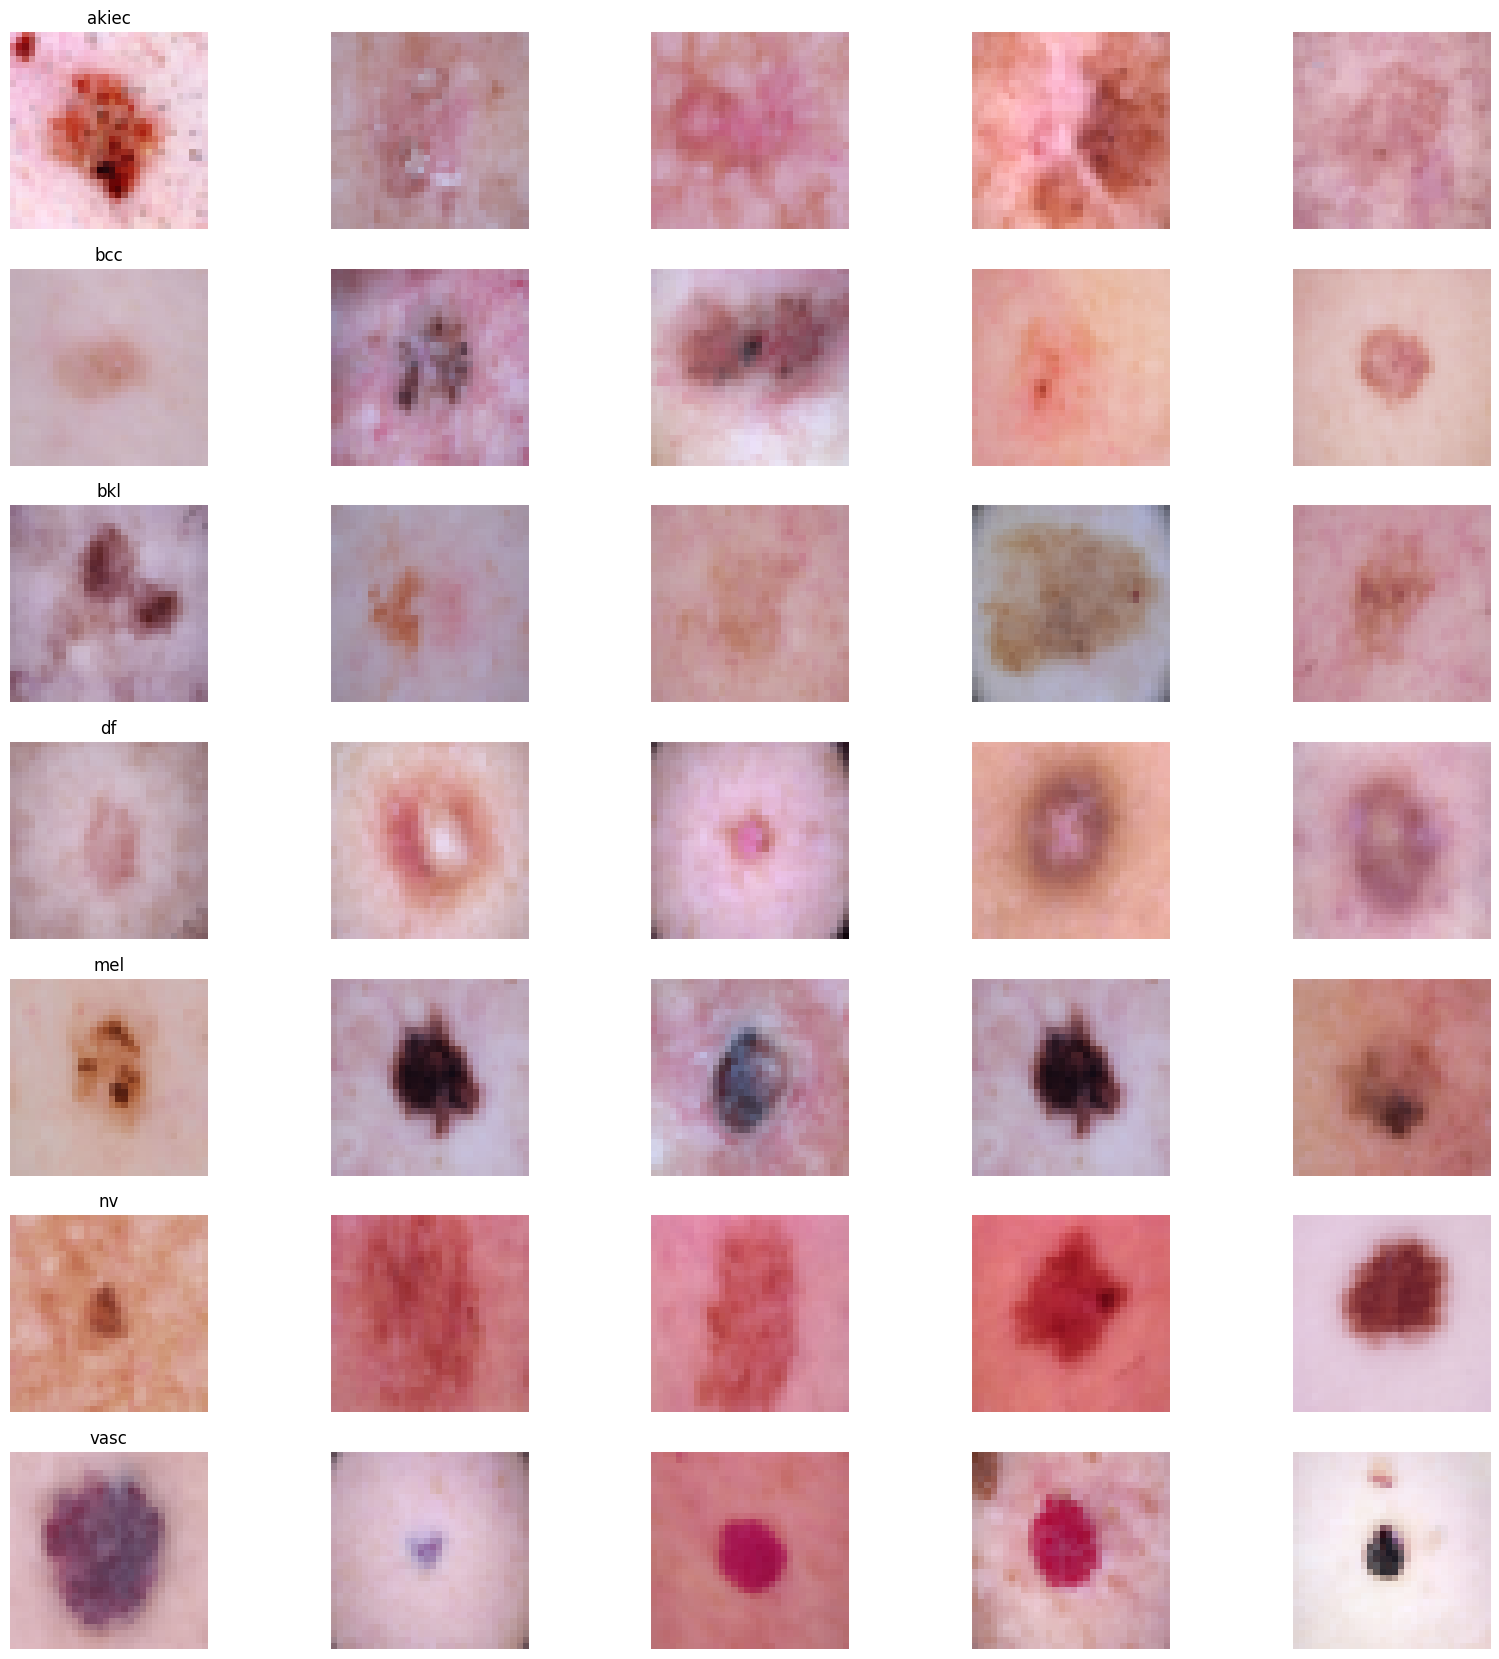

In [11]:
# https://youtu.be/fyZ9Rxpoz2I
"""
Skin cancer lesion classification using the HAM10000 dataset
Autokeras to find the best model.

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description:
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc)
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
!pip install autokeras
import autokeras as ak

skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')


SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be
# fitting it to many potential models.
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

#Further split data into smaller size to get a small test dataset.
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)

#Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=25) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=25)


#Evaluate the classifier on test data
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()
print(model.summary())

#Save the model
model.save('cifar_model.h5')


score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

/tmp/ipython-input-1902020977.py:74: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


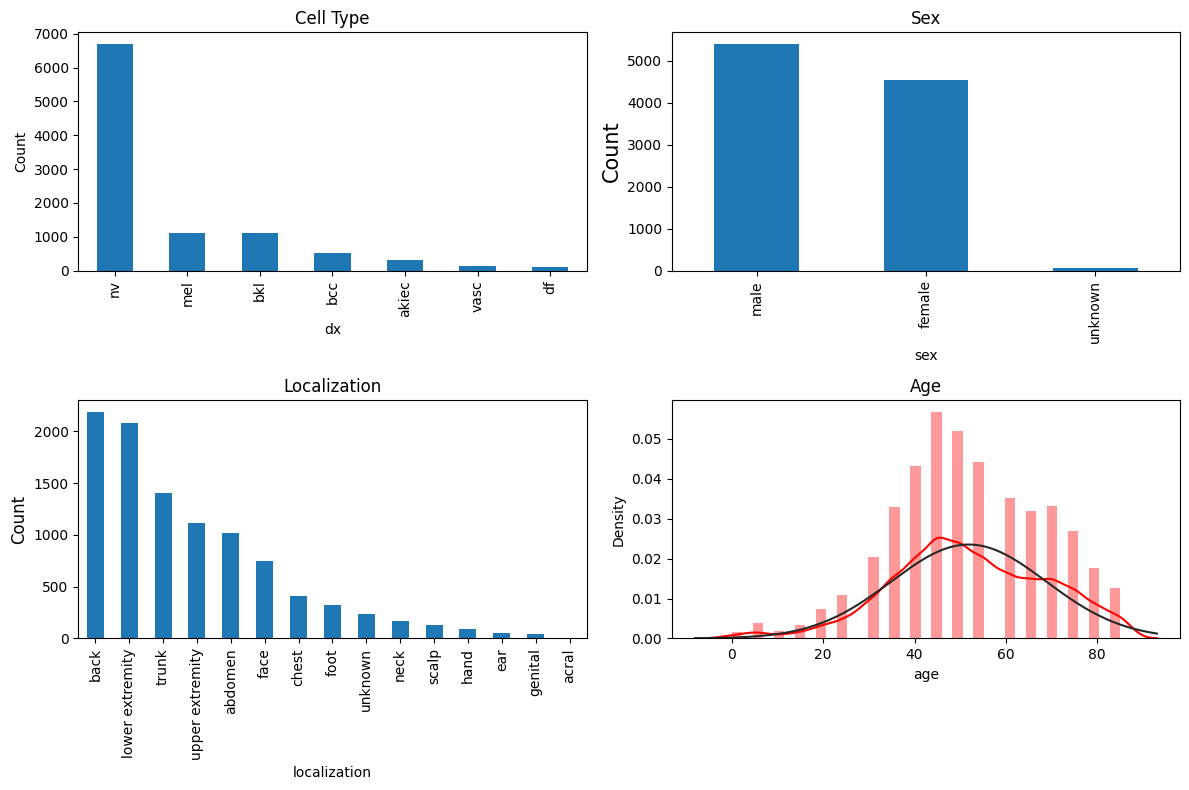

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
165/165 - 12s - 74ms/step - acc: 0.1924 - loss: 1.9025 - val_acc: 0.2217 - val_loss: 1.8175
Epoch 2/50
165/165 - 1s - 6ms/step - acc: 0.2933 - loss: 1.7148 - val_acc: 0.3360 - val_loss: 1.6124
Epoch 3/50
165/165 - 1s - 6ms/step - acc: 0.3973 - loss: 1.5118 - val_acc: 0.3760 - val_loss: 1.4565
Epoch 4/50
165/165 - 1s - 6ms/step - acc: 0.4152 - loss: 1.4415 - val_acc: 0.4000 - val_loss: 1.4951
Epoch 5/50
165/165 - 1s - 7ms/step - acc: 0.4625 - loss: 1.3822 - val_acc: 0.4366 - val_loss: 1.3339
Epoch 6/50
165/165 - 1s - 6ms/step - acc: 0.4907 - loss: 1.3215 - val_acc: 0.4640 - val_loss: 1.3059
Epoch 7/50
165/165 - 1s - 7ms/step - acc: 0.4884 - loss: 1.2989 - val_acc: 0.4914 - val_loss: 1.2859
Epoch 8/50
165/165 - 1s - 8ms/step - acc: 0.5044 - loss: 1.2646 - val_acc: 0.5074 - val_loss: 1.2357
Epoch 9/50
165/165 - 1s - 6ms/step - acc: 0.5013 - loss: 1.2694 - val_acc: 0.4617 - val_loss: 1.3106
Epoch 10/50
165/165 - 1s - 6ms/step - acc: 0.5234 - loss: 1.2188 - val_acc: 0.4971 - val_

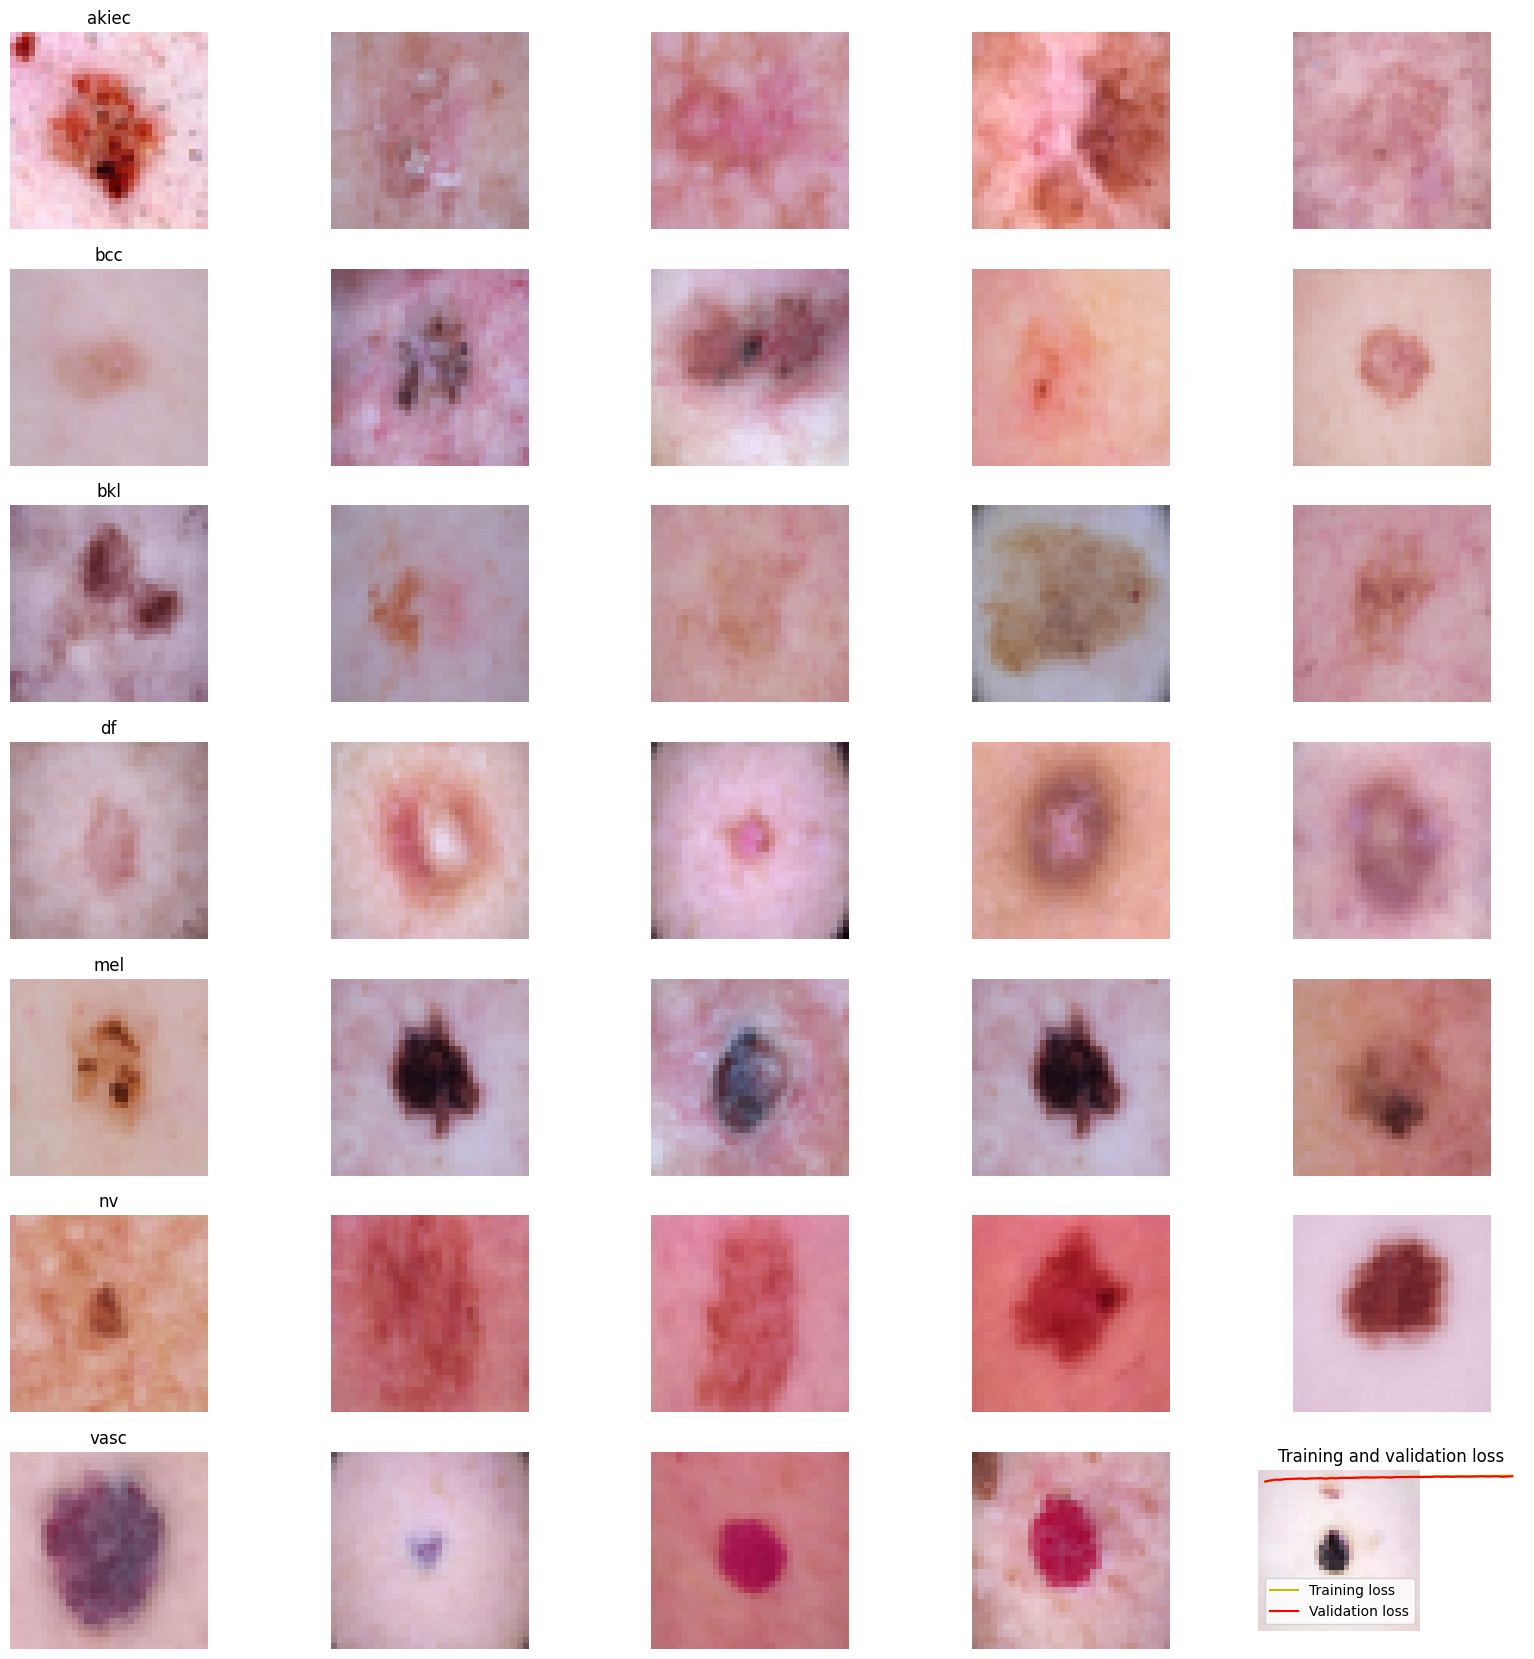

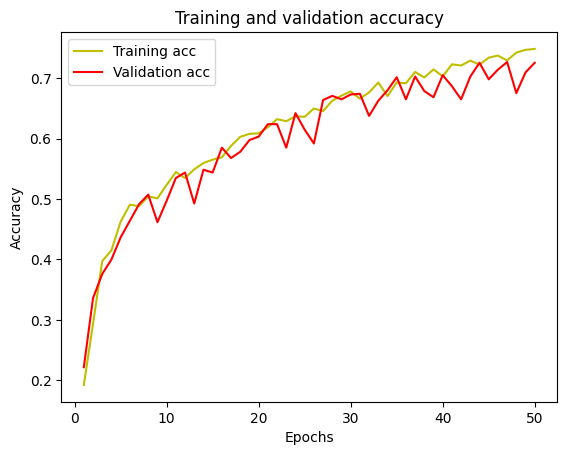

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Text(45.722222222222214, 0.5, 'Fraction of incorrect predictions')

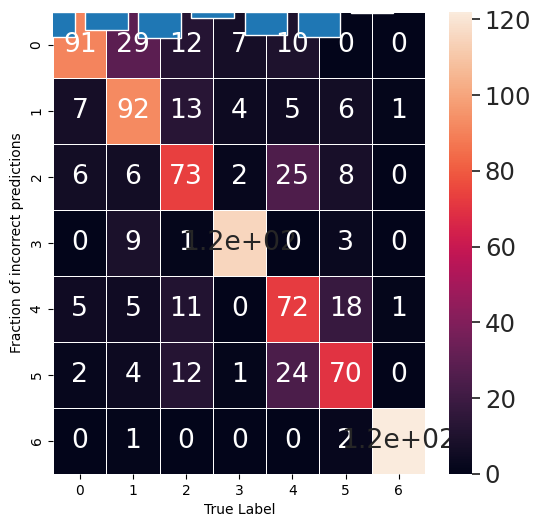

In [13]:
# https://youtu.be/fyZ9Rxpoz2I
"""
Skin cancer lesion classification using the HAM10000 dataset

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description:
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc)
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('data/HAM10000/HAM10000_metadata.csv')

SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.histplot(sample_age['age'], kde=True, color='red', ax=ax4); # Changed to histplot
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 16
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
